In [695]:
from typing import Union
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PatchCollection
import matplotlib.patches as mpatches
import matplotlib.path as mpath
from numpy.typing import ArrayLike, NDArray
from sympy import *

from cycloid.main import Pins
from cycloid.symmath import offset_line, cycloid
np.set_printoptions(precision=4, suppress=True)

In [2]:
%load_ext autoreload
%autoreload 2
%aimport cycloid
# %aimport src.utils.box_cutter
# %aimport src.utils.classes
# %aimport src.utils.data_worker


In [772]:
# TODO Parameterize these variables in the cycloid contruction 
# i.e `10` should be a reference to the number of teeth on the 
# cycloid gear.
step = 10
pix = 40
rad = 2 * np.pi / 10                              # `rad` is the length in radians of one cycloidal rotation ("tooth")

n = np.linspace(0, step-1, step)                  # `n` is just a list of numbers that modify measurements for 
                                                  # each gear tooth, e.g. [0, 1, 2, ..., 10]
a = n * rad                                       # `a` is the starting position of each tooth profile in radians

# cosa, sina are the x, y components of a rotation
# that will be applied to the d/dt of the offset
# curve of the cycloid.
#
# These rotations around the base circle: `n+1/2` * `rad`
# describes the number of tooth position rotations needed
# from each position to align the tooth profile around the
# origin.
#
# This alignment is used to measure the curvature of the
# offset cycloid and 'trim' the parts of the function that
# aren't wanted for the final gear profile.
cosa = np.cos((n+1/2)*-rad)
sina = np.sin((n+1/2)*-rad)

t = np.linspace(a, a + rad, pix).swapaxes(0, 1)  # t is just the time step, or the value passed to the function that generates
                                                 # the cycloidal curve. Defaults to 40 points/tooth profile.

# rot is the rotation matrix applied to the derivative curve later the result
# of which can be used to create a mask to trim the extra points of the offset
# curve.
rot = np.array([[cosa, -sina],
                [sina, cosa]], dtype=np.float32).transpose(2, 0, 1)

In [773]:
# pulling in the callable functions derived using sympy ./cycloid/symmath.py
f1, f2, f3 = cycloid()
# f1 is the base cycloid, f2 is the offset curve of f1, f3 = d/dt[f2]
fxy = f1(t).squeeze().transpose(1,2,0) # getting a set of points from f1(t) with shape (num_teeth, num_points, 2) default: (10, 40, 2)

i: 10.0
r2: 1.25
e: 1.125


In [774]:
f2xy = f2(t).squeeze().transpose(1, 2, 0)
f2xy.shape

(10, 40, 2)

In [777]:
# this cell prepares the output of f3(t) and applies the rotation matrix to it
d3 = f3(t).transpose(2, 3, 0, 1)
rot_copy = np.repeat(np.expand_dims(rot, axis=1), pix, axis=1)
d3_r = np.matmul(rot_copy, d3) # Apply the rotation to each tooth
d3_r.shape, rot_copy.shape # just checking to make sure the shapes look right

((10, 40, 2, 1), (10, 40, 2, 2))

In [783]:
# Masking the output of f2(t) i.e. the offset curve function to trim the 
# parts of the curve that intersect themselves.
mask = np.less(d3_r[:,:,-1:,:], 0)   # it's hard to explain in words but by rotating each part of the tooth to the same alignment
                                 # we can just trim any y value of d/dt [f2(t)] that dips below zero.
mask.shape

(10, 40, 1, 1)

In [784]:
mask = np.repeat(mask, 2, axis=2)
m_f2xy = np.ma.masked_array(f2xy, mask=mask.squeeze()) # then apply that mask to f2(t) to trim the profile.

In [785]:
# The rest is just setting up the matplotlib stuff.
# 
# In this cell the connections between the trimmed offset tooth curves are set up. This is all
# hardcoded and will break right away.
Path = mpath.Path
start = f2xy[:, 13:14, :]
stop = f2xy[:, 27:28:, :]
beg = np.pi / 10
inc = 2 * beg
end = 2*np.pi - beg
circ = np.linspace(beg, end, 10, dtype=np.float32)
radius = 12.5 - 2.5
mid = np.array([radius*np.cos(circ), radius*np.sin(circ)], dtype=np.float32).transpose(1, 0).reshape(10, 1, 2)

curve = np.concatenate([start, mid, stop], axis=1)
instr = [Path.MOVETO, Path.CURVE3, Path.CURVE3]


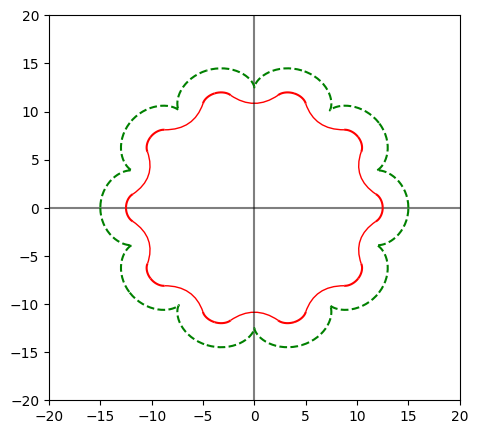

In [786]:
# dump all the numpy arrays we calculated into `LineCollection`s
ddxy = LineCollection(d3_r.squeeze())
g_fxy = LineCollection(fxy, edgecolors="green", linestyles="--")
g_f2xy = LineCollection(m_f2xy, edgecolors="red")
# Iterate through the curve point arrays and construct a bunch of patch objects from Path objects
bez = []
for idx in range(10):
    bez.append(mpatches.PathPatch(
            Path(curve[idx], instr), fc="none"))
curve_col = PatchCollection(bez, facecolors="none", edgecolors="red")
# Draw the graph
fig, ax = plt.subplots(figsize=(5.3, 5))
ax.set(
    xlim = [-20,20],
    ylim = [-20,20]
    )
ax.vlines(x=0, ymin=-40, ymax=40, color="black", alpha=.5)
ax.hlines(y=0, xmin=-40, xmax=40, color="black", alpha=.5)
ax.add_collection(g_fxy)
ax.add_collection(g_f2xy)
ax.add_collection(curve_col)
plt.show()